# Actor-Critic network for finding the shortest path on a KG

The KGML-xDTD MOA prediction module is based on an Adverserial Actor-Critic RL model based on demonstration . 

The purpose of this notebook is to provide an initial exploration of this type of algorithm. 

A reinforcement learning agent for MOA prediction finds paths from drug nodes to disease nodes which are "biologically meaningful" in the sense of being likely to comprise MOAs. 

As a starting point, we consider the simpler problem: *find a path in the KG from a given drug node to a given disease node*.

## Executive Summary
- By comparing to random walk baselines, we observe that we successfully train a model for 
- Performance could probably be further improved by investing more time into hyperparameter tuning - this is just a quick proof of concept.
- Random walks are more effective at path-finding than I would naively have expected, suggesting the problem is not too difficult. Perhaps we should explore non-ML algorithms for path-finding, combined with a supervised MOA vs. not-MOA classification model for paths.

In [1]:
import pandas as pd
import polars as pl # much faster than pandas
import numpy as np
import matplotlib.pyplot as plt
import igraph as ig
import torch
import torch.nn as nn
import torch.nn.functional as F

from time import time
import random
import pickle
from tqdm import tqdm
import sys
import importlib

## KG environment

First, we set up the knowledge graph environment class which the agent interacts. 

A primary function of this class is to:
 - For any given node, be able to return all successor neighbour nodes and embeddings. 
 - For any given node, be able to return out-going edges and one-hot embeddings for their predicates.

As these operations are repeated in every training step, they must be done quickly. For instance, calling a neo4j server directly to achieve this in prohibitively slow. To achieve sufficient speed, we use the graph package igraph combined with PyTorch for dealing with the embeddings.  



In [2]:
# KG filepath
KG_NODES_PATH = '/Users/alexei/Documents/data/KGML_xDTD_data/KG/nodes_c.tsv'
KG_NODES_HEADER_PATH = '/Users/alexei/Documents/data/KGML_xDTD_data/KG/nodes_c_header.tsv'
KG_EDGES_PATH = '/Users/alexei/Documents/data/KGML_xDTD_data/KG/edges_c.tsv'
KG_EDGES_HEADER_PATH ='/Users/alexei/Documents/data/KGML_xDTD_data/KG/edges_c_header.tsv'
# GraphSAGE embeddings filepath 
GRAPHSAGE_EMB_PATH = '/Users/alexei/Documents/data/KGML_xDTD_data/data/entity_embeddings/unsuprvised_graphsage_entity_embeddings.pkl'
# PubMedBERT embeddings filepath 
PUBMED_EMB_PATH = '/Users/alexei/Documents/data/KGML_xDTD_data/data/entity_embeddings/embedding_biobert_namecat.pkl'

In [3]:
class KGEnv:
    """
    A class representing a knowledge graph enriched with embeddings.  
    """
    def __init__(self, 
                 kg_nodes_filepath: str,
                 kg_nodes_header_filepath: str,
                 kg_edges_filepath: str, 
                 kg_edges_header_filepath: str, 
                 embeddings_filepath: str,
                 id_col_name = "id:ID", 
                 predicate_col_name = "predicate",
                 subject_col_name = "subject",
                 object_col_name = "object", 
                 device = 'cpu'
                 ) -> None:
        """Initialises instance of the KGEnv class.

        Args:
            kg_nodes_filepath: File path for tsv file containing the KG nodes.
            kg_nodes_header_filepath: File path for tsv file containing the header for the KG nodes.
            kg_edges_filepath: File path for tsv file containing the KG edges.
            kg_edges_header_filepath: File path for tsv file containing the header for the KG edges.
            embeddings_filepath: File path for a pickle file containing an KG ID to embedding vector dictionary.
            id_col_name: Column name for KG ID in nodes tsv file.
            predicate_col_name: Column name for KG edge predicate in edges tsv file. 
            subject_col_name: Column name for KG edge subject in edges tsv file.
            object_col_name: Column name for KG edge object in edges tsv file.
        """
        self.device = device

        # Load nodes
        print("Loading nodes...")
        nodes_header = pd.read_csv(kg_nodes_header_filepath, sep='\t', header=None).iloc[0].to_list()
        df_nodes = pl.read_csv(kg_nodes_filepath, separator='\t', has_header= False, new_columns=nodes_header)
        df_nodes = df_nodes.with_row_index()
        # Load edges
        print("Loading edges...")
        edges_header = pd.read_csv(kg_edges_header_filepath, sep='\t', header=None).iloc[0].to_list()
        df_edges = pl.read_csv(kg_edges_filepath, separator='\t', has_header= False, new_columns=edges_header)
        
        # Generate KG ID to index dictionary for nodes
        print("Generating igraph Graph instance...")
        self.node_id_to_index = {key: val for key, val in zip(list(df_nodes[id_col_name]), list(df_nodes["index"]))}
        # Generate edge predicate to index dictionary
        unique_predicates = pl.DataFrame(df_edges[predicate_col_name].unique())
        unique_predicates = unique_predicates.with_row_index()
        self.edge_predicate_to_index = {key: val for key, val in zip(list(unique_predicates[predicate_col_name]), list(unique_predicates["index"]))}
        self.N_edge_labels = len(self.edge_predicate_to_index)
        # Generating igraph Graph instance
        edges = [(self.node_id_to_index[subject], self.node_id_to_index[object]) for subject, object in zip(df_edges[subject_col_name],df_edges[object_col_name])]
        edge_labels = {"edge_label":[self.edge_predicate_to_index[predicate] for predicate in df_edges[predicate_col_name]]}
        self.graph = ig.Graph(edges=edges, directed=True, edge_attrs = edge_labels)
        # Remove nodes and edges from memory
        del df_nodes
        del df_edges

        # Load embeddings
        print("Loading embeddings...")
        with open(embeddings_filepath, 'rb') as file:
            embedding_dict = pickle.load(file)
        # Dimensions of embeddings matrix
        self.N_emb = len(list(embedding_dict.values())[0])
        self.N_items = len(self.node_id_to_index)        
        # Generate 2d torch tensor for embeddings. If no embedding exists, we use the zero embedding
        print("Generating embeddings matrix...")
        self.embedding_matrix = torch.zeros((self.N_items, self.N_emb))
        for _id, n in self.node_id_to_index.items():
            if _id in embedding_dict.keys():
                self.embedding_matrix[n, :] = torch.tensor(embedding_dict[_id])
        self.embedding_matrix.to(device) 
        # Remove embedding dictionary from memory
        del embedding_dict

        # Matrix for one-hot edge embeddings
        self._edge_embedding_matrix = torch.eye(self.N_edge_labels).to(device)

        print("Initialisation successful.")


    def get_nhood_nodes(self, n: int) -> torch.Tensor:
        """Returns successor node indices and corresponding embeddings.

        Args:
            n: igraph node index

        Returns:
            Tuple where the:
                - first element is a list of indices for successor nodes. 
                - second element is a 2d torch tensor with the corresponding embeddings.
            If there are no successor nodes, then a tuple of two None objects is returned.
        """
        successor_list = self.graph.successors(n)
        if len(successor_list) == 0:
            return None, None
        else:
            return successor_list, self.embedding_matrix[successor_list]


    def get_out_edges(self, n: int) -> torch.Tensor:
        """Returns outgoing edge predicate indices and corresponding one-hot embeddings.

        Args:
            n: igraph node index

        Returns:
            Tuple where the:
                - first element is a list of indices for the predicates of all out edges. 
                - second element is a 2d torch tensor with the one-hot embeddings.
            If there are outgoing edges, then a tuple of two None objects is returned.
        """
        # Get indices of out edges
        edge_list = self.graph.vs[n].out_edges()
        if len(edge_list) == 0:
            return None, None
        edge_labels_lst = [edge["edge_label"] for edge in edge_list]
        # Return corresponding one-hot embeddings
        return edge_labels_lst, self._edge_embedding_matrix[edge_labels_lst]

In [4]:
# Initialise KG environment
kg_env = KGEnv(KG_NODES_PATH, KG_NODES_HEADER_PATH, KG_EDGES_PATH, KG_EDGES_HEADER_PATH, GRAPHSAGE_EMB_PATH)

Loading nodes...
Loading edges...
Generating igraph Graph instance...
Loading embeddings...
Generating embeddings matrix...
Initialisation successful.


## State representation

Let $u$ represent the source drug and the $v$ the target disease. 

At each time step $t$, the agent performs an action consisting in traversing from one node $e_t$ to another $e_{t+1}$ across an edge with a given label $r_{t+1}$ .  An action is represented by a tuple $a_t = (e_{t+1}, r_{t+1})$, where $r_{t+1}$ is the edge predicate index and $e_{t+1}$ is the igraph index for the new node. 

Future actions depends only on the current state. 

There are two options for representing the state. Let $K \in \mathbb{N}$ be a cap on the number of edges in a path. 
1. Target disease accessible:
$$ s_t = [u, v, (e_{t-K}, r_{t-K}), ..., (e_{t-1}, r_{t-1}), (e_{t}, r_{t})]$$
2. Target disease inaccessible:
$$ s_t = [u, (e_{t-K}, r_{t-K}), ..., (e_{t-1}, r_{t-1}), (e_{t}, r_{t})]$$

The first corresponds to the case where the agent makes MOA predictions after a drug-disease relationship has already been made. 

The second corresponds to the case where the agent finds make disease predictions for a given drug and simultaneously provides MOA predictions. 

Zhou et. al. and KGML-xDTD opt for the second option. We shall initially focus on the first option for the $u \rightarrow v$ path-finding problem. 

**Note:** If $t \leq 0$, we replace $(e_{t}, r_{t})$ by a dummy variable $(-1,-1)$. For instance, in the first option above the initial state is
$$s_0 = (u, v, (-1,-1),...,(-1,-1)).$$

*Remark.* We could in principle let the maximum number of edges in a path be greater than the history included in the state.  

In [5]:
# Maximum allowed number of edges in a path
K = 5 

In [6]:
class Agent:
    """A class representing a reinforcement learning agent in a knowledge graph environment.  
    """
    def __init__(self, K: int, kg_env: KGEnv) -> None:
        """Initialises Agent instance.

        Args:
            K: Maximum allowed number of edges in a path
            kg_env: Instance of KGEnv 
        """
        self.K = K
        self.kg_env = kg_env
        # Initiate time
        self.time = 0
        # Initialise empty state attributes
        self.reset()

    def set_source_target(self, drug : int, disease :int) -> None:
        """Sets source drug and target diseases. Resets state to canonical initial state.  

        Args:
            drug: igraph node index for the source drug
            disease: igraph node index for the target drug
        """
        # Reset time and termination status
        self.time = 0
        self.terminated = False

        # Set drug and disease indices
        self.source_drug = drug
        self.target_disease = disease
        
        # Set drug and disease embeddings
        self.source_drug_embedding = self.kg_env.embedding_matrix[drug]
        self.target_disease_embedding = self.kg_env.embedding_matrix[disease]

        # Set initial state
        self.current_state = [drug, disease] + [(-1,-1) for _ in range(self.K)]
        self.current_node = drug
        # Set initial state embedding matrix
        embeddings_tmp = torch.zeros((self.K + 2, self.kg_env.N_emb + self.kg_env.N_edge_labels))
        embeddings_tmp[0][:self.kg_env.N_emb] = self.source_drug_embedding
        embeddings_tmp[1][:self.kg_env.N_emb] = self.target_disease_embedding
        self.current_state_embedding = embeddings_tmp

        # Compute list of next possible actions
        self.compute_possible_next_actions()

    def reset(self) -> None:
        """Resets time and empties state attributes
        """
        self.time = 0
        self.terminated = False
        self.source_drug = None
        self.source_drug_embedding = None
        self.target_disease = None
        self.target_disease_embedding = None
        self.current_state = None
        self.current_state_embedding = None

    def compute_possible_next_actions(self) -> None:
        """Sets attributes containing list of next possible actions and corresponding embeddings. 
        """
        # Call KG environment to get nhood information
        successor_list, successor_embeddings_matrix = self.kg_env.get_nhood_nodes(self.current_node)
        edge_labels_list, edge_labels_embeddings_matrix = self.kg_env.get_out_edges(self.current_node)
        # Set attributes
        if successor_list == None:
            self.all_actions = None
            self.all_actions_embeddings = None
            self.terminated = True
        else: 
            self.all_actions =  [
                (node_index, predicate_index) for node_index, predicate_index in zip(successor_list, edge_labels_list)
                ]
            self.all_actions_embeddings = torch.cat((successor_embeddings_matrix, edge_labels_embeddings_matrix), 1)

    def select_next_action(self, n_next_action: str):
        """Selects an admitted action and updates the agent.

        Args:
            n_next_action: Index of self.all_actions corresponding to selected next action
        """
        if self.terminated == True: 
            print("Maximum path length reached.")
            return

        # Update current state and current node
        next_action = self.all_actions[n_next_action]
        self.current_node = next_action[0]
        self.current_state[2:-1] = self.current_state[3:]
        self.current_state[-1] = next_action

        # Update current state embedding 
        next_action_embedding = self.all_actions_embeddings[n_next_action]
        next_state_embedding = self.current_state_embedding.clone()
        next_state_embedding[2:-1] = self.current_state_embedding[3:]
        next_state_embedding[-1] = next_action_embedding
        self.current_state_embedding = next_state_embedding

        # Update time 
        self.time += 1
        if self.time == K:
            self.terminated = True

        # Update list of next possible actions
        self.compute_possible_next_actions()




In [7]:
# Test
drug, disease = 10, 42
agent = Agent(K, kg_env)
agent.set_source_target(drug,disease)
print(agent.current_state)
print(agent.current_state_embedding)

[10, 42, (-1, -1), (-1, -1), (-1, -1), (-1, -1), (-1, -1)]
tensor([[-0.0173,  0.0888,  0.0172,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0049,  0.0685,  0.0038,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


In [8]:
# Test
agent.compute_possible_next_actions()
print(agent.all_actions)
print(agent.all_actions_embeddings)

[(14984, 22), (16202, 22), (17456, 22), (17463, 22), (17935, 22), (17939, 22), (17945, 22), (17954, 22), (17969, 22), (17978, 22), (17979, 22), (18041, 22), (19175, 22), (19674, 22), (19825, 22), (20694, 22), (27303, 22), (27304, 22), (27326, 22), (27328, 22), (27330, 22), (27510, 22), (27987, 22), (28111, 22), (28784, 22), (28842, 22), (28846, 22), (29127, 22), (29711, 22), (29938, 22), (30182, 22), (30620, 22), (30661, 22), (32704, 22), (34601, 22), (35288, 22), (37142, 22), (37171, 22), (37541, 22), (37664, 22), (39829, 22), (40214, 33), (40319, 22), (43100, 22), (43139, 22), (43310, 22), (46065, 22), (46152, 22), (48768, 22), (49012, 22), (50255, 22), (50266, 22), (53257, 61), (55493, 22), (55819, 22), (58944, 22), (59556, 22), (61908, 22), (63385, 22), (64529, 22), (66616, 22), (71524, 22), (72277, 22), (73019, 22), (73903, 22), (79219, 22), (79864, 22), (81316, 22), (81336, 22), (81508, 22), (82505, 22), (84827, 22), (86269, 22), (86545, 22), (87150, 22), (88193, 22), (90728, 22)

In [9]:
# Test
drug, disease = 10, 42
agent = Agent(K, kg_env)
agent.set_source_target(drug,disease)
print(agent.current_state)
print(agent.current_state_embedding)
agent.select_next_action(0)
print(agent.current_state)
print(agent.current_state_embedding)
agent.select_next_action(0)
print(agent.current_state)
print(agent.current_state_embedding)
agent.select_next_action(0)

[10, 42, (-1, -1), (-1, -1), (-1, -1), (-1, -1), (-1, -1)]
tensor([[-0.0173,  0.0888,  0.0172,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0049,  0.0685,  0.0038,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])
[10, 42, (-1, -1), (-1, -1), (-1, -1), (-1, -1), (14984, 22)]
tensor([[-0.0173,  0.0888,  0.0172,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0049,  0.0685,  0.0038,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0345,  0.0680,  0.0141,  ...,  0.0000,  0.0000,  0.0000]])
[10, 42, (-

## Actor network

In [10]:
class ActorFCNN(nn.Module):
    """Pytorch module representing the actor network. 

    Architecture is a fully connected neural network. 

    TODO: Remove LazyLinear in prod code (feature still under development)
    """
    def __init__(self, 
                 neuron_lst : list[int],
                 N_emb : int, 
                 N_edge_labels: int,
                 activation_fn = nn.ReLU,
                 ) -> None:
        """Initialises instance of ActorFCNN. 

        Args:
            neuron_lst: A list containing the number of neurons in each hidden layer. 
                The length of the list determines the number of hidden layers. 
            N_emb: Length of node embedding vectors. 
            N_edge_labels: Length of edge predicate embedding vectors
            activation_fn: Activation function for all hidden layers. Defaults to nn.ReLU.
        """
        super().__init__()
        # Dimension of embedding of a single action 
        action_emb_dim = N_emb + N_edge_labels
        # Construct main stack 
        self.main_stack = nn.Sequential()
        for idx, n in enumerate(neuron_lst):
            self.main_stack.add_module(f'Linear {idx + 1}', nn.LazyLinear(n))
            self.main_stack.add_module(f'Activation {idx + 1}', activation_fn())
        self.main_stack.add_module('Linear output', nn.LazyLinear(action_emb_dim))

    def forward(self, state_embedding: torch.Tensor, all_actions_embeddings: torch.Tensor): 
        """Performs forward propagation. 

        Args:
            state_embedding: 2d torch tensor representing current state embedding 
            all_actions_embeddings: 2d torch tensor embeddings for all possible next actions
        """
        x = state_embedding.flatten()
        z = self.main_stack(x)
        return F.softmax(all_actions_embeddings @ z, dim = 0)        
        

In [11]:
# Test
neuron_lst = [10,10]
actor = ActorFCNN(neuron_lst, kg_env.N_emb, kg_env.N_edge_labels)
print(actor(agent.current_state_embedding, agent.all_actions_embeddings))
print(torch.argmax(actor(agent.current_state_embedding, agent.all_actions_embeddings)).item())

tensor([0.0222, 0.0222, 0.0217, 0.0209, 0.0204, 0.0324, 0.0200, 0.0296, 0.0331,
        0.0319, 0.0352, 0.0184, 0.0329, 0.0281, 0.0283, 0.0361, 0.0366, 0.0296,
        0.0192, 0.0381, 0.0307, 0.0359, 0.0216, 0.0416, 0.0367, 0.0375, 0.0370,
        0.0365, 0.0416, 0.0179, 0.0195, 0.0349, 0.0209, 0.0306],
       grad_fn=<SoftmaxBackward0>)
23


In [12]:
def run_path(agent: Agent, actor: nn.Module, drug: int, disease: int) -> list:
    # Reset agent
    agent.set_source_target(drug, disease)
    # Compute path
    path = [agent.current_node]
    while agent.terminated == False:
        probs_next_action = actor(agent.current_state_embedding, agent.all_actions_embeddings)
        n_next_action = torch.argmax(probs_next_action).item()
        agent.select_next_action(n_next_action)    
        path.append(agent.current_node)
    return path


In [13]:
# Test
K = 5
neuron_lst = [10,10]
drug = 10
disease = 42

for _ in range (5):
    actor = ActorFCNN(neuron_lst, kg_env.N_emb, kg_env.N_edge_labels)
    agent = Agent(K, kg_env)
    print(run_path(agent, actor, drug, disease))

[10, 27987, 2304176]
[10, 27987, 17969, 111417, 37703, 33540]
[10, 180675, 172693, 191259, 446027, 446028]
[10, 251997]
[10, 238678, 247143, 251352, 251351]


## Critic network

In [14]:
class CriticFCNN(nn.Module):
    """Pytorch module representing the critic network. 

    Architecture is a fully connected neural network. 

    TODO: Remove LazyLinear in prod code (feature still under development)
    """
    def __init__(self, 
                 neuron_lst : list[int],
                 N_emb : int, 
                 N_edge_labels: int,
                 activation_fn = nn.ReLU,
                 ) -> None:
        """Initialises instance of CriticFCNN. 

        Args:
            neuron_lst: A list containing the number of neurons in each hidden layer. 
                The length of the list determines the number of hidden layers. 
            N_emb: Length of node embedding vectors. 
            N_edge_labels: Length of edge predicate embedding vectors
            activation_fn: Activation function for all hidden layers. Defaults to nn.ReLU.
        """
        super().__init__()
        # Dimension of embedding of a single action 
        action_emb_dim = N_emb + N_edge_labels
        # Construct main stack 
        self.main_stack = nn.Sequential()
        for idx, n in enumerate(neuron_lst):
            self.main_stack.add_module(f'Linear {idx + 1}', nn.LazyLinear(n))
            self.main_stack.add_module(f'Activation {idx + 1}', activation_fn())
        self.main_stack.add_module('Linear output', nn.LazyLinear(action_emb_dim))

    def forward(self, state_embedding: torch.Tensor, next_action_embedding: torch.Tensor):
        """Performs forward propagation. 

        Args:
            state_embedding: 2d torch tensor representing current state embedding 
            next_action_embedding: 1d torch tensor embeddings for an action
        """
        x = state_embedding.flatten()
        z = self.main_stack(x)
        return next_action_embedding @ z        


In [18]:
# Test
neuron_lst = [10,10]
agent = Agent(K,kg_env)
agent.set_source_target(10,42)
critic = CriticFCNN(neuron_lst, kg_env.N_emb, kg_env.N_edge_labels)
print(critic(agent.current_state_embedding, agent.all_actions_embeddings[0]))

tensor(0.0552, grad_fn=<DotBackward0>)


## Datasets

In order to establish a baseline for MOA prediction algorithms, we shall train a model for the drug to disease path finding problem.


In [19]:
# Ground truth positive
df_tp = pd.read_csv('/Users/alexei/Documents/data/KGML_xDTD_data/known_pairs/tp_pairs.txt', sep='\t')

In [20]:
# Mapping to igraph indices
df_tp_mapped = df_tp.map(lambda x: kg_env.node_id_to_index[x])
# Convert to list of tuples
tp_mapped_lst = [(row["source"], row["target"]) for _, row in df_tp_mapped.iterrows()]

In [21]:
# Loading MOA demonstration paths dataset
with open('../DrugMechDB/output/all_separated_paths.pickle', 'rb') as file:
    moa_paths = pickle.load(file) 

In [22]:
# Transforming each MOA path to form [u, e_1, ..., e_{n-1}, v]
#   where u, v, e_j are the igraph indices of the drug, disease and node indices. 
moa_mapped_lst = []
for moa_path in moa_paths:
    moa_path_mapped = [kg_env.node_id_to_index[node_id] for _, node_id in moa_path]
    moa_mapped_lst.append(moa_path_mapped)

In [23]:
# List of TP DD pairs based on the MOA demonstration paths
moa_mapped_DD_lst = [(moa[0], moa[-1]) for moa in moa_mapped_lst]

## 

In [24]:
print("Number of MOA paths without corresponding pair in ground truth dataset:", len(set(moa_mapped_DD_lst) - set(tp_mapped_lst)), " out of ", len(moa_mapped_DD_lst) )

Number of MOA paths without corresponding pair in ground truth dataset: 328  out of  5598


In [25]:
# Reducing MOA dataset to only those with a corresponding pair in ground truth dataset
moa_reduced_lst = [moa for moa in moa_mapped_lst if (moa[0], moa[-1]) in tp_mapped_lst]

In [26]:
# Test-train split for ground truth positive dataset
tp_test_lst = [(moa[0], moa[-1]) for moa in moa_reduced_lst]
tp_test_lst = list(set(tp_test_lst))
tp_train_lst = list(set(tp_mapped_lst) - set(tp_test_lst))

In [27]:
# Test 
len(tp_test_lst) + len(tp_train_lst) == len(tp_mapped_lst)

True

In [28]:
# Test : no ground truth pairs as edges 
test_passed = True
for drug, disease in tqdm(tp_mapped_lst):
    if drug in [edge.index for edge in kg_env.graph.vs[disease].out_edges()]:
        test_passed = False
    if disease in [edge.index for edge in kg_env.graph.vs[drug].out_edges()]:
        test_passed = False
print("test passed: ", test_passed )

100%|██████████| 21437/21437 [00:02<00:00, 8733.27it/s]

test passed:  True


## Training 

In this notebook, we consider a terminal reward whereby the agent is rewarded for taking an action $a = (e, r)$ in a state $s$, as follows
$$
r(s,a) = \begin{cases} 1 & \textrm{if the node } e \textrm{ is the target disease}\\
0 & \textrm{otherwise}
\end{cases}
$$
The state-value function $q_\pi$ for policy $\pi$ is defined as the expected cumulative reward:
$$
q_\pi(s,a)  = \mathbb{E}_\pi[\sum_{j} \gamma^j r_j] 
$$
where $\set{r_j}$ is set of rewards achieved along the path until termination and $\gamma \in (0, 1]$ is the discount factor. 

Recall the Bellman equation for the state-value function:
$$q_\pi(s, a) = r(s,a) + \gamma \mathbb{E}_{a'\sim\pi} q_\pi(s', a') $$
where $s'$ is the state entered as a result of taking action $a$ in state $s$.

The critic network $Q$ aims to approximate the state-value function. To do this we enforce the Bellman equation using the so-called temporal difference loss:
$$
L_Q(s, a ; Q, \pi ) = (r(s,a) + \gamma \mathbb{E}_{a'\sim\pi} Q(s', a') - Q(s,a))^2.
$$

The loss for the actor network is
$$
L_\pi(s ; Q, \pi) = - \mathbb{E}_{a\sim\pi} Q(s, a).
$$

The training process is performed using an $\epsilon$-greedy strategy.

- In each epoch, we loop over the ground-truth positive training drug-disease pairs. 
- Each drug-disease pair in the epoch coresponds to an episode.
- In each episode, 
    1. Start at the drug.
    2. Choose the next action as follows.  
        - With probability $1 - \epsilon$, sample according to actor policy $\pi$.
        - With probability $\epsilon$, sample randomly. 
    3. Perform gradient step. 
    4. Repeat steps 2 and 3 until termination. 

In [29]:
# Reward function 

def terminal_reward(disease : int, next_action : tuple[int]) -> float:
    """_summary_

    Args:
        disease: _description_
        next_action: _description_
    """
    if next_action[0] == disease:
        return 1
    else: 
        return 0

In [30]:
# Main training loop

def train(
    kg_env : KGEnv, 
    K : int,
    actor_neuron_lst : list[int],
    critic_neuron_lst : list[int],
    N_epochs : int,
    gamma : float,
    epsilon : float,
    M : int, 
    optimiser : callable,
    verbose = True,
    device = 'cpu'
) -> tuple[nn.Module]:
    """Train Actor-Critic network.

    Function for use in current notebook only. 

    Args:
        kg_env: Instance of KGEnv.
        K: Max number of hops. 
        actor_neuron_lst: Size of all hidden layers in actor network.
        critic_neuron_lst: Size of all hidden layers in critic network.
        N_epochs: Number of epochs.
        gamma: Discount factor. 
        epsilon: Controls epsilon-greedy policy. 
        M: (Maximum) Number of DD pairs cycled through per epoch. 
        optimiser: Function of PyTorch parameters representing optimiser. 
        verbose: Print updates during training.

    Returns:
        Tuple containing:
            - trained actor and critic networks
            - histories for average total, actor and critic loss function values per epoch.
    """
    # Initialise agent, actor network and critic networks
    agent = Agent(K, kg_env)
    actor = ActorFCNN(actor_neuron_lst, kg_env.N_emb, kg_env.N_edge_labels).to(device)
    critic = CriticFCNN(critic_neuron_lst, kg_env.N_emb, kg_env.N_edge_labels).to(device)

    # Initialise optimiser 
    optimiser_actor = optimiser(actor.parameters())
    optimiser_critic = optimiser(critic.parameters())

    # Book-keeping 
    loss_hist = []
    actor_loss_hist = []
    critic_loss_hist = []
    n_per_epoch = len(tp_train_lst[:M])

    # Training loop
    for epoch in range(N_epochs):
        # Variables for tracking total loss for epoch
        loss_epoch = 0
        actor_loss_epoch = 0
        critic_loss_epoch = 0
        # Variable for tracking number of rewards per epoch
        n_rewards_epoch = 0
        for (drug, disease) in tqdm(tp_train_lst[:M]):
            # Reset agent
            agent.set_source_target(drug,disease)
            current_state_embedding = agent.current_state_embedding
            all_actions = agent.all_actions
            all_actions_embeddings = agent.all_actions_embeddings

            # Next episode if there are no available actions
            if all_actions == None:
                continue

            # Run path 
            loss_episode_total = 0
            actor_loss_episode_total = 0
            critic_loss_episode_total = 0
            len_path = 0
            for _ in range (K): 
                #  Compute actor policy distribution for current state
                policy_probabilities = actor(current_state_embedding, all_actions_embeddings)
                
                # Choose next action 
                do_exploit = random.choices([True, False], weights = [1 - epsilon, epsilon])[0]
                if do_exploit:
                    # Sample from actor policy
                    n_next_action = random.choices(range(len(all_actions)), weights = policy_probabilities.tolist())[0]
                else:
                    # Sample from randomly
                    n_next_action = random.choices(range(len(all_actions)))[0]
                next_action = all_actions[n_next_action]
                next_action_embedding = all_actions_embeddings[n_next_action]
                    
                # Compute actor loss
                all_critic_values = critic(current_state_embedding, all_actions_embeddings)
                loss_actor =  - all_critic_values @ policy_probabilities

                # Backpropagation actor
                optimiser_actor.zero_grad()
                loss_actor.backward()
                optimiser_actor.step()

                # Compute reward and critic value for chosen action
                current_critic_value = critic(current_state_embedding, next_action_embedding)
                reward = terminal_reward(disease, next_action)
                
                # Update agent 
                agent.select_next_action(n_next_action)
                current_state_embedding = agent.current_state_embedding
                all_actions = agent.all_actions
                all_actions_embeddings = agent.all_actions_embeddings

                # Next episode if the path terminates 
                if agent.terminated == True:
                    break

                # Compute temporal difference loss for critic
                new_critic_values = critic(current_state_embedding, all_actions_embeddings)
                new_policy_probabilities = actor(current_state_embedding, all_actions_embeddings)
                new_expectation_critic =  new_critic_values @ new_policy_probabilities
                loss_critic = (reward + gamma * new_expectation_critic - current_critic_value)**2

                # Backpropagation critic
                optimiser_critic.zero_grad()
                loss_critic.backward()
                optimiser_critic.step()

                # Record history
                len_path += 1
                loss_episode_total += (loss_actor + loss_critic).item()
                actor_loss_episode_total += loss_actor.item()
                critic_loss_episode_total += loss_critic.item()
                if reward == 1:
                    n_rewards_epoch += 1

                # Next episode if disease has been successfully reached
                if agent.current_node == disease:
                    break
                
            # Record history
            if len_path > 0:
                loss_epoch += loss_episode_total / len_path
                actor_loss_epoch += actor_loss_episode_total / len_path
                critic_loss_epoch += critic_loss_episode_total / len_path

        # Record history        
        loss_hist.append(loss_epoch / n_per_epoch)
        actor_loss_hist.append(actor_loss_epoch / n_per_epoch)
        critic_loss_hist.append(critic_loss_epoch / n_per_epoch)

        print(f"Epoch {epoch + 1}. Rewards awarded: {n_rewards_epoch}. Average loss: {loss_epoch / n_per_epoch}.")
    return actor, critic, loss_hist, actor_loss_hist, critic_loss_hist
    

#### Training a tiny NN

In [31]:
# Model hyperparameters
K = 5
actor_neuron_lst = [10,10]
critic_neuron_lst = [10,10]

# Training parameters
N_epochs = 50
gamma =  0.9
epsilon = 0
M = 100 # (max) number of DD pairs in epoch
optimiser = lambda params : torch.optim.Adam(params)

mini_actor, mini_critic, loss_hist, actor_loss_hist, critic_loss_hist = train(kg_env,
    K, 
    actor_neuron_lst,
    critic_neuron_lst,
    N_epochs,
    gamma,
    epsilon,
    M, 
    optimiser
)

100%|██████████| 100/100 [00:00<00:00, 101.07it/s]


Epoch 1. Rewards awarded: 0. Average loss: -0.2782675093063153.


100%|██████████| 100/100 [00:00<00:00, 135.65it/s]


Epoch 2. Rewards awarded: 0. Average loss: -0.20013891485364488.


100%|██████████| 100/100 [00:00<00:00, 103.47it/s]


Epoch 3. Rewards awarded: 0. Average loss: -0.21146244321018456.


100%|██████████| 100/100 [00:00<00:00, 112.47it/s]


Epoch 4. Rewards awarded: 1. Average loss: -0.20413715464994311.


100%|██████████| 100/100 [00:00<00:00, 114.84it/s]


Epoch 5. Rewards awarded: 1. Average loss: -0.1852591521618888.


100%|██████████| 100/100 [00:00<00:00, 106.53it/s]


Epoch 6. Rewards awarded: 1. Average loss: -0.1743308163806796.


100%|██████████| 100/100 [00:00<00:00, 113.30it/s]


Epoch 7. Rewards awarded: 1. Average loss: -0.11700795887969434.


100%|██████████| 100/100 [00:00<00:00, 139.38it/s]


Epoch 8. Rewards awarded: 1. Average loss: -0.060229427348822355.


100%|██████████| 100/100 [00:00<00:00, 204.54it/s]


Epoch 9. Rewards awarded: 2. Average loss: -0.1295243142855664.


100%|██████████| 100/100 [00:00<00:00, 200.83it/s]


Epoch 10. Rewards awarded: 1. Average loss: -0.05339397150676329.


100%|██████████| 100/100 [00:00<00:00, 172.47it/s]


Epoch 11. Rewards awarded: 2. Average loss: -0.06345645807758654.


100%|██████████| 100/100 [00:00<00:00, 185.31it/s]


Epoch 12. Rewards awarded: 1. Average loss: -0.08361457551198935.


100%|██████████| 100/100 [00:00<00:00, 148.78it/s]


Epoch 13. Rewards awarded: 1. Average loss: -0.031232111956002576.


100%|██████████| 100/100 [00:00<00:00, 164.03it/s]


Epoch 14. Rewards awarded: 1. Average loss: -0.0543100533997737.


100%|██████████| 100/100 [00:00<00:00, 162.50it/s]


Epoch 15. Rewards awarded: 1. Average loss: -0.02417750010426971.


100%|██████████| 100/100 [00:00<00:00, 177.77it/s]


Epoch 16. Rewards awarded: 1. Average loss: -0.0023094266441815612.


100%|██████████| 100/100 [00:00<00:00, 171.04it/s]


Epoch 17. Rewards awarded: 1. Average loss: -0.008850432654805142.


100%|██████████| 100/100 [00:00<00:00, 162.35it/s]


Epoch 18. Rewards awarded: 1. Average loss: -0.014558684511393949.


100%|██████████| 100/100 [00:00<00:00, 168.57it/s]


Epoch 19. Rewards awarded: 3. Average loss: 0.0254383489076857.


100%|██████████| 100/100 [00:00<00:00, 176.34it/s]


Epoch 20. Rewards awarded: 7. Average loss: 0.01080462637629049.


100%|██████████| 100/100 [00:00<00:00, 158.25it/s]


Epoch 21. Rewards awarded: 6. Average loss: -0.06627754973325257.


100%|██████████| 100/100 [00:00<00:00, 159.89it/s]


Epoch 22. Rewards awarded: 6. Average loss: -0.06634156459525305.


100%|██████████| 100/100 [00:00<00:00, 169.04it/s]


Epoch 23. Rewards awarded: 7. Average loss: -0.06660956246273902.


100%|██████████| 100/100 [00:00<00:00, 170.07it/s]


Epoch 24. Rewards awarded: 8. Average loss: -0.06860747988025347.


100%|██████████| 100/100 [00:00<00:00, 149.65it/s]


Epoch 25. Rewards awarded: 8. Average loss: -0.0588499084704866.


100%|██████████| 100/100 [00:00<00:00, 148.23it/s]


Epoch 26. Rewards awarded: 8. Average loss: -0.05172057718737051.


100%|██████████| 100/100 [00:00<00:00, 196.90it/s]


Epoch 27. Rewards awarded: 7. Average loss: -0.07078292553283973.


100%|██████████| 100/100 [00:00<00:00, 182.15it/s]


Epoch 28. Rewards awarded: 8. Average loss: -0.08056859092786908.


100%|██████████| 100/100 [00:00<00:00, 187.26it/s]


Epoch 29. Rewards awarded: 8. Average loss: -0.09015931836329401.


100%|██████████| 100/100 [00:00<00:00, 183.10it/s]


Epoch 30. Rewards awarded: 7. Average loss: -0.10456890938493114.


100%|██████████| 100/100 [00:00<00:00, 185.95it/s]


Epoch 31. Rewards awarded: 8. Average loss: -0.0868819439589667.


100%|██████████| 100/100 [00:00<00:00, 155.42it/s]


Epoch 32. Rewards awarded: 8. Average loss: -0.0648987615579972.


100%|██████████| 100/100 [00:00<00:00, 199.50it/s]


Epoch 33. Rewards awarded: 8. Average loss: -0.06360230505738097.


100%|██████████| 100/100 [00:00<00:00, 186.12it/s]


Epoch 34. Rewards awarded: 9. Average loss: -0.07030337322445121.


100%|██████████| 100/100 [00:00<00:00, 194.93it/s]


Epoch 35. Rewards awarded: 8. Average loss: -0.10116782228928059.


100%|██████████| 100/100 [00:00<00:00, 185.45it/s]


Epoch 36. Rewards awarded: 8. Average loss: -0.061664817391429094.


100%|██████████| 100/100 [00:00<00:00, 187.01it/s]


Epoch 37. Rewards awarded: 10. Average loss: -0.06157729588216171.


100%|██████████| 100/100 [00:00<00:00, 175.83it/s]


Epoch 38. Rewards awarded: 8. Average loss: -0.05691182767506689.


100%|██████████| 100/100 [00:00<00:00, 191.64it/s]


Epoch 39. Rewards awarded: 8. Average loss: -0.07331835494958795.


100%|██████████| 100/100 [00:00<00:00, 200.17it/s]


Epoch 40. Rewards awarded: 8. Average loss: -0.06697759878753762.


100%|██████████| 100/100 [00:00<00:00, 214.19it/s]


Epoch 41. Rewards awarded: 9. Average loss: -0.0441702149399498.


100%|██████████| 100/100 [00:00<00:00, 212.49it/s]


Epoch 42. Rewards awarded: 8. Average loss: -0.062394943101826354.


100%|██████████| 100/100 [00:00<00:00, 192.26it/s]


Epoch 43. Rewards awarded: 8. Average loss: -0.05804014099509611.


100%|██████████| 100/100 [00:00<00:00, 178.48it/s]


Epoch 44. Rewards awarded: 8. Average loss: -0.07400281726634907.


100%|██████████| 100/100 [00:00<00:00, 176.57it/s]


Epoch 45. Rewards awarded: 8. Average loss: -0.07122258115482206.


100%|██████████| 100/100 [00:00<00:00, 188.44it/s]


Epoch 46. Rewards awarded: 8. Average loss: -0.08864240726378438.


100%|██████████| 100/100 [00:00<00:00, 192.32it/s]


Epoch 47. Rewards awarded: 7. Average loss: -0.08486274663824588.


100%|██████████| 100/100 [00:00<00:00, 189.03it/s]


Epoch 48. Rewards awarded: 8. Average loss: -0.08318962830739718.


100%|██████████| 100/100 [00:00<00:00, 174.73it/s]


Epoch 49. Rewards awarded: 7. Average loss: -0.09571577985247132.


100%|██████████| 100/100 [00:00<00:00, 172.49it/s]

Epoch 50. Rewards awarded: 8. Average loss: -0.09118636062679192.


Text(0.5, 0, 'Epoch')

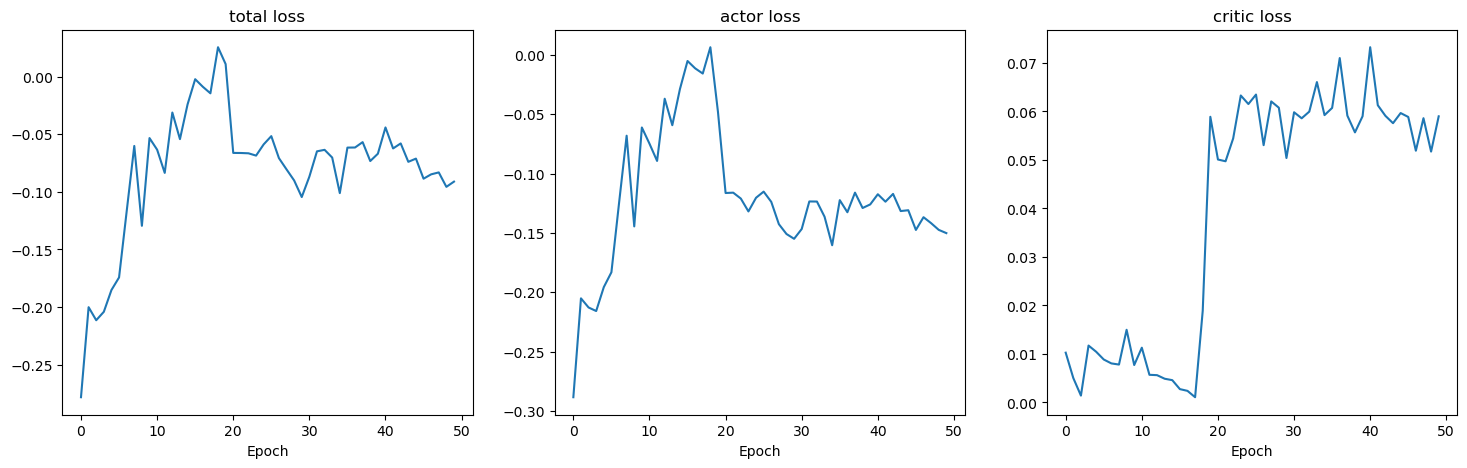

In [32]:
# Plot training curve
fig, ax = plt.subplots( 1, 3, figsize = (18, 5))
ax[0].plot(loss_hist)
ax[0].set_title("total loss")
ax[0].set_xlabel("Epoch")
ax[1].plot(actor_loss_hist)
ax[1].set_title("actor loss")
ax[1].set_xlabel("Epoch")
ax[2].plot(critic_loss_hist)
ax[2].set_title("critic loss")
ax[2].set_xlabel("Epoch")

## Evaluation

In [33]:
def sample_path(agent: Agent, actor: nn.Module, drug: int, disease: int) -> list[int]:
    """Randomly samples a actor policy path starting from a drug node. 

    Path terminated in target disease is reached.

    Args:
        agent: Instance of Agent class.
        actor: Actor network. 
        drug: igraph index for the source drug.
        disease: igraph index for the target disease.

    Returns:
        List of igraph indices.
    """
    # Reset agent
    agent.set_source_target(drug, disease)
    # Compute path
    path = [agent.current_node]
    while agent.terminated == False:
        probs_next_action = actor(agent.current_state_embedding, agent.all_actions_embeddings)
        n_next_action = random.choices(range(len(agent.all_actions)), weights = probs_next_action.tolist())[0]
        agent.select_next_action(n_next_action)    
        path.append(agent.current_node)
        if agent.current_node == disease:
            return path
    return path

In [34]:
def give_hits_list(
        n_samples : int,
        n_datapoints : int,
        f_sample: callable,
        dataset : list[tuple[int]]
    ) -> list:
    """Gives number of samples until hit list for an actor policy. 

    Args:
        n_samples: Maximum number of 
        n_datapoints: Maximum number of datapoints. 
        f_sample: Function sampling paths from actor-agent.
        drug: igraph index for the source drug.
        disease: igraph index for the target disease.

    Returns:
        List of elements:
            - False if a path to disease was not found, otherwise,
            - number of samples it took to get a path to disease. 
    """
    hits_lst = []
    disease_reached = False
    for drug, disease in tqdm(dataset[:n_datapoints]):
        for n in range(n_samples):
            path = f_sample(drug, disease) 
            if path[-1] == disease:
                disease_reached = True
                hits_lst.append(n+1)
                break
        if not disease_reached:
            hits_lst.append(False)
        disease_reached = False

    return hits_lst

def give_hitk(hits_lst, k_lst):
    """_summary_

    Args:
        hits_lst: _description_
        k_lst: _description_
    """
    filter_hits_lst = [n for n in hits_lst if n != False]
    hitk = []
    for k in k_lst:
        hitk.append(sum([n <= k for n in filter_hits_lst]) / len(hits_lst)) 
    return hitk
    

In [35]:
# Baselines

def sample_random_path(agent: Agent, drug: int, disease: int) -> list[int]:
    """Randomly samples a actor policy path starting from a drug node. 

    Path terminates if target disease is reached.

    Args:
        agent: Instance of Agent class.
        drug: igraph index for the source drug.
        disease: igraph index for the target disease.

    Returns:
        List of igraph indices.
    """
    # Reset agent
    agent.set_source_target(drug, disease)
    # Compute path
    path = [agent.current_node]
    while agent.terminated == False:
        n_next_action = random.choices(range(len(agent.all_actions)))[0]
        agent.select_next_action(n_next_action)    
        path.append(agent.current_node)
        if agent.current_node == disease:
            return path
    return path

### Establishing baselines

In [36]:
K = 5
k_lst = [10, 100, 500, 1000]
n_samples = 1000
n_datapoints = 100
dataset = tp_test_lst
agent = Agent(K, kg_env)


#### Random walk

In [37]:
# Computing hits list for random walk 
f_random_sample = lambda drug, disease: sample_random_path(agent, drug, disease)
random_hits_list = give_hits_list(n_samples, n_datapoints, f_random_sample, dataset)

100%|██████████| 100/100 [02:37<00:00,  1.58s/it]


In [38]:
# Compute Hit@k for random walk
hitk_random =  give_hitk(random_hits_list, k_lst)
print("Random walk:")
for hitk_val, k in zip(hitk_random, k_lst): 
    print(f"Hit@{k}: {hitk_val}")


Random walk:
Hit@10: 0.05
Hit@100: 0.18
Hit@500: 0.48
Hit@1000: 0.73


#### Untrained network

In [39]:
# Computing hits list for untrained actor 
actor = ActorFCNN([10, 10], kg_env.N_emb, kg_env.N_edge_labels) 
f_untrained = lambda drug, disease: sample_path(agent, actor, drug, disease)
untrained_hits_list = give_hits_list(n_samples, n_datapoints, f_untrained, dataset)


100%|██████████| 100/100 [03:04<00:00,  1.85s/it]


In [40]:
# Compute Hit@k for untrained actor 
hitk_untrained =  give_hitk(untrained_hits_list, k_lst)
print("Untrained network:")
for hitk_val, k in zip(hitk_untrained, k_lst): 
    print(f"Hit@{k}: {hitk_val}")

Untrained network:
Hit@10: 0.06
Hit@100: 0.23
Hit@500: 0.59
Hit@1000: 0.76


#### Trained mini network

In [41]:
# Computing hits list for trained actor 
f_trained = lambda drug, disease: sample_path(agent, mini_actor, drug, disease)
trained_hits_list = give_hits_list(n_samples, n_datapoints, f_trained, dataset)

100%|██████████| 100/100 [01:23<00:00,  1.20it/s]


In [42]:
# Compute Hit@k for trained mini actor 
hitk_trained =  give_hitk(trained_hits_list, k_lst)
print("Trained mini network:")
for hitk_val, k in zip(hitk_trained, k_lst): 
    print(f"Hit@{k}: {hitk_val}")

Trained mini network:
Hit@10: 0.13
Hit@100: 0.14
Hit@500: 0.15
Hit@1000: 0.17


The Hit@10 has increased significantly while Hit@1000 has decreased significantly. 

This makes sense since we sample from the policy only once per episode. 

The Hit@1000 being quite close to Hit@10 is probably a consequence of the entropy of the actor policy decreasing with training. An entropy regularisation term (as in KGML-xDTD MOAP model) in the cost function could help rectify this.  Also we could change the sampling stratgy to tree-based. 

Note also that this was only a very small neural network. 

## Bigger network

In [ ]:
# GPU training : crashes since embedding matrix is too large to be stored on GPU memory
# Initialise KG environment
#kg_env = KGEnv(KG_NODES_PATH, KG_NODES_HEADER_PATH, KG_EDGES_PATH, KG_EDGES_HEADER_PATH, GRAPHSAGE_EMB_PATH, device = 'mps')

In [47]:
# Model hyperparameters
K = 5
actor_neuron_lst = [1000,500, 100]
critic_neuron_lst = [1000,500, 100]

# Training parameters
N_epochs = 250
gamma =  0.9
epsilon = 0.05
M = 500 # (max) number of DD pairs in epoch
optimiser = lambda params : torch.optim.SGD(params, lr=0.003)

trained_actor, trained_critic, loss_hist, actor_loss_hist, critic_loss_hist = train(kg_env,
    K, 
    actor_neuron_lst,
    critic_neuron_lst,
    N_epochs,
    gamma,
    epsilon,
    M, 
    optimiser
)

100%|██████████| 500/500 [00:31<00:00, 15.95it/s]


Epoch 1. Rewards awarded: 9. Average loss: 0.05365639060842417.


100%|██████████| 500/500 [00:32<00:00, 15.48it/s]


Epoch 2. Rewards awarded: 12. Average loss: 0.02638278697031395.


100%|██████████| 500/500 [00:31<00:00, 15.67it/s]


Epoch 3. Rewards awarded: 9. Average loss: 0.01585530705619385.


100%|██████████| 500/500 [00:30<00:00, 16.37it/s]


Epoch 4. Rewards awarded: 10. Average loss: 0.014516015665095286.


100%|██████████| 500/500 [00:32<00:00, 15.62it/s]


Epoch 5. Rewards awarded: 9. Average loss: 0.012436403026293192.


100%|██████████| 500/500 [00:31<00:00, 16.06it/s]


Epoch 6. Rewards awarded: 10. Average loss: 0.011801585245593136.


100%|██████████| 500/500 [00:30<00:00, 16.19it/s]


Epoch 7. Rewards awarded: 7. Average loss: 0.008704663017335482.


100%|██████████| 500/500 [00:32<00:00, 15.33it/s]


Epoch 8. Rewards awarded: 6. Average loss: 0.006721576909623763.


100%|██████████| 500/500 [00:31<00:00, 15.93it/s]


Epoch 9. Rewards awarded: 9. Average loss: 0.009610191528969152.


100%|██████████| 500/500 [00:29<00:00, 17.19it/s]


Epoch 10. Rewards awarded: 12. Average loss: 0.007973549843074579.


100%|██████████| 500/500 [00:29<00:00, 16.94it/s]


Epoch 11. Rewards awarded: 11. Average loss: 0.00437009425096888.


100%|██████████| 500/500 [00:30<00:00, 16.59it/s]


Epoch 12. Rewards awarded: 11. Average loss: 0.0021784576826855.


100%|██████████| 500/500 [00:31<00:00, 15.84it/s]


Epoch 13. Rewards awarded: 9. Average loss: -0.0005800801707352244.


100%|██████████| 500/500 [00:32<00:00, 15.16it/s]


Epoch 14. Rewards awarded: 5. Average loss: -0.0016263565958743128.


100%|██████████| 500/500 [00:30<00:00, 16.64it/s]


Epoch 15. Rewards awarded: 10. Average loss: 0.006527628011117488.


100%|██████████| 500/500 [00:30<00:00, 16.67it/s]


Epoch 16. Rewards awarded: 9. Average loss: 0.0016589576384843294.


100%|██████████| 500/500 [00:29<00:00, 17.10it/s]


Epoch 17. Rewards awarded: 9. Average loss: 0.006735563420936159.


100%|██████████| 500/500 [00:30<00:00, 16.64it/s]


Epoch 18. Rewards awarded: 6. Average loss: 0.004113283876552183.


100%|██████████| 500/500 [00:29<00:00, 16.80it/s]


Epoch 19. Rewards awarded: 7. Average loss: 0.00693943524274846.


100%|██████████| 500/500 [00:29<00:00, 16.78it/s]


Epoch 20. Rewards awarded: 8. Average loss: 0.005189975064428533.


100%|██████████| 500/500 [00:29<00:00, 17.12it/s]


Epoch 21. Rewards awarded: 8. Average loss: 0.0040538910669323126.


100%|██████████| 500/500 [00:30<00:00, 16.64it/s]


Epoch 22. Rewards awarded: 14. Average loss: 0.010793048551056322.


100%|██████████| 500/500 [00:31<00:00, 15.89it/s]


Epoch 23. Rewards awarded: 10. Average loss: 0.005478863311192072.


100%|██████████| 500/500 [00:31<00:00, 15.71it/s]


Epoch 24. Rewards awarded: 11. Average loss: 0.006154685438873759.


100%|██████████| 500/500 [00:32<00:00, 15.55it/s]


Epoch 25. Rewards awarded: 6. Average loss: -0.000665254309575782.


100%|██████████| 500/500 [00:31<00:00, 15.71it/s]


Epoch 26. Rewards awarded: 11. Average loss: 0.00850499890465077.


100%|██████████| 500/500 [00:31<00:00, 15.65it/s]


Epoch 27. Rewards awarded: 7. Average loss: 0.004394366326231648.


100%|██████████| 500/500 [00:32<00:00, 15.37it/s]


Epoch 28. Rewards awarded: 8. Average loss: 0.004003322339421477.


100%|██████████| 500/500 [00:30<00:00, 16.28it/s]


Epoch 29. Rewards awarded: 13. Average loss: 0.00921307013090033.


100%|██████████| 500/500 [00:30<00:00, 16.65it/s]


Epoch 30. Rewards awarded: 9. Average loss: 0.0010306373885347658.


100%|██████████| 500/500 [00:31<00:00, 16.07it/s]


Epoch 31. Rewards awarded: 7. Average loss: 0.000542061373108784.


100%|██████████| 500/500 [00:30<00:00, 16.20it/s]


Epoch 32. Rewards awarded: 7. Average loss: 0.0034998277312018526.


100%|██████████| 500/500 [00:30<00:00, 16.22it/s]


Epoch 33. Rewards awarded: 11. Average loss: 0.00680581848450644.


100%|██████████| 500/500 [00:29<00:00, 16.71it/s]


Epoch 34. Rewards awarded: 10. Average loss: 0.0029265497170276066.


100%|██████████| 500/500 [00:29<00:00, 16.71it/s]


Epoch 35. Rewards awarded: 10. Average loss: 0.004524371143350095.


100%|██████████| 500/500 [00:30<00:00, 16.44it/s]


Epoch 36. Rewards awarded: 10. Average loss: 0.005755961384299249.


100%|██████████| 500/500 [00:29<00:00, 16.80it/s]


Epoch 37. Rewards awarded: 11. Average loss: 0.010931120962346538.


100%|██████████| 500/500 [00:29<00:00, 16.92it/s]


Epoch 38. Rewards awarded: 13. Average loss: 0.008329386855635069.


100%|██████████| 500/500 [00:30<00:00, 16.66it/s]


Epoch 39. Rewards awarded: 10. Average loss: 0.0056630960850783.


100%|██████████| 500/500 [00:30<00:00, 16.51it/s]


Epoch 40. Rewards awarded: 9. Average loss: 0.004543406140874443.


100%|██████████| 500/500 [00:30<00:00, 16.65it/s]


Epoch 41. Rewards awarded: 10. Average loss: 0.006376033610658851.


100%|██████████| 500/500 [00:29<00:00, 16.84it/s]


Epoch 42. Rewards awarded: 10. Average loss: 0.0078722605601021.


100%|██████████| 500/500 [00:32<00:00, 15.51it/s]


Epoch 43. Rewards awarded: 10. Average loss: 0.00812407386641947.


100%|██████████| 500/500 [00:29<00:00, 16.87it/s]


Epoch 44. Rewards awarded: 9. Average loss: 0.005967267459453069.


100%|██████████| 500/500 [00:29<00:00, 16.91it/s]


Epoch 45. Rewards awarded: 10. Average loss: 0.005709096512528656.


100%|██████████| 500/500 [00:29<00:00, 17.12it/s]


Epoch 46. Rewards awarded: 15. Average loss: 0.010391939399865805.


100%|██████████| 500/500 [00:29<00:00, 17.05it/s]


Epoch 47. Rewards awarded: 16. Average loss: 0.007453011818722794.


100%|██████████| 500/500 [00:29<00:00, 16.96it/s]


Epoch 48. Rewards awarded: 13. Average loss: 0.002761638692241225.


100%|██████████| 500/500 [00:29<00:00, 16.89it/s]


Epoch 49. Rewards awarded: 9. Average loss: 0.004067983592855549.


100%|██████████| 500/500 [00:29<00:00, 17.12it/s]


Epoch 50. Rewards awarded: 16. Average loss: 0.013502540391070093.


100%|██████████| 500/500 [00:29<00:00, 17.22it/s]


Epoch 51. Rewards awarded: 14. Average loss: 0.005937452589781364.


100%|██████████| 500/500 [00:29<00:00, 17.14it/s]


Epoch 52. Rewards awarded: 12. Average loss: 0.005562064730026577.


100%|██████████| 500/500 [00:30<00:00, 16.61it/s]


Epoch 53. Rewards awarded: 12. Average loss: 0.0057553129360179206.


100%|██████████| 500/500 [00:29<00:00, 17.13it/s]


Epoch 54. Rewards awarded: 17. Average loss: 0.01087998930327255.


100%|██████████| 500/500 [00:28<00:00, 17.31it/s]


Epoch 55. Rewards awarded: 11. Average loss: 0.0037296293011192267.


100%|██████████| 500/500 [00:30<00:00, 16.65it/s]


Epoch 56. Rewards awarded: 10. Average loss: 0.0028502612292286363.


100%|██████████| 500/500 [00:30<00:00, 16.66it/s]


Epoch 57. Rewards awarded: 12. Average loss: 0.006527162931248312.


100%|██████████| 500/500 [00:28<00:00, 17.47it/s]


Epoch 58. Rewards awarded: 15. Average loss: 0.011123005153812605.


100%|██████████| 500/500 [00:29<00:00, 17.09it/s]


Epoch 59. Rewards awarded: 18. Average loss: 0.010258401993222529.


100%|██████████| 500/500 [00:29<00:00, 16.98it/s]


Epoch 60. Rewards awarded: 13. Average loss: 0.003365530805554349.


100%|██████████| 500/500 [00:29<00:00, 17.08it/s]


Epoch 61. Rewards awarded: 18. Average loss: 0.004975464190840436.


100%|██████████| 500/500 [00:30<00:00, 16.51it/s]


Epoch 62. Rewards awarded: 16. Average loss: 0.012219412974699783.


100%|██████████| 500/500 [00:29<00:00, 16.98it/s]


Epoch 63. Rewards awarded: 8. Average loss: 0.0020966511548675348.


100%|██████████| 500/500 [00:29<00:00, 16.97it/s]


Epoch 64. Rewards awarded: 17. Average loss: 0.01580830647012681.


100%|██████████| 500/500 [00:29<00:00, 17.08it/s]


Epoch 65. Rewards awarded: 18. Average loss: 0.013872509948912922.


100%|██████████| 500/500 [00:29<00:00, 17.11it/s]


Epoch 66. Rewards awarded: 15. Average loss: 0.011294550334722464.


100%|██████████| 500/500 [00:29<00:00, 17.11it/s]


Epoch 67. Rewards awarded: 13. Average loss: 0.011176727660624237.


100%|██████████| 500/500 [00:29<00:00, 16.95it/s]


Epoch 68. Rewards awarded: 13. Average loss: 0.012279341049954382.


100%|██████████| 500/500 [00:29<00:00, 17.20it/s]


Epoch 69. Rewards awarded: 24. Average loss: 0.02000940020329229.


100%|██████████| 500/500 [00:29<00:00, 16.78it/s]


Epoch 70. Rewards awarded: 18. Average loss: 0.014533126417030265.


100%|██████████| 500/500 [00:32<00:00, 15.40it/s]


Epoch 71. Rewards awarded: 17. Average loss: 0.017361531590032123.


100%|██████████| 500/500 [00:32<00:00, 15.32it/s]


Epoch 72. Rewards awarded: 18. Average loss: 0.016528125615683776.


100%|██████████| 500/500 [00:28<00:00, 17.28it/s]


Epoch 73. Rewards awarded: 19. Average loss: 0.020099889271577923.


100%|██████████| 500/500 [00:28<00:00, 17.52it/s]


Epoch 74. Rewards awarded: 26. Average loss: 0.03199541403183381.


100%|██████████| 500/500 [00:29<00:00, 17.20it/s]


Epoch 75. Rewards awarded: 17. Average loss: 0.014534407666078704.


100%|██████████| 500/500 [00:28<00:00, 17.56it/s]


Epoch 76. Rewards awarded: 15. Average loss: 0.009831815486443095.


100%|██████████| 500/500 [00:28<00:00, 17.55it/s]


Epoch 77. Rewards awarded: 23. Average loss: 0.019557857258703428.


100%|██████████| 500/500 [00:28<00:00, 17.47it/s]


Epoch 78. Rewards awarded: 22. Average loss: 0.021160280803950934.


100%|██████████| 500/500 [00:29<00:00, 17.02it/s]


Epoch 79. Rewards awarded: 19. Average loss: 0.013076240792992393.


100%|██████████| 500/500 [00:29<00:00, 17.19it/s]


Epoch 80. Rewards awarded: 20. Average loss: 0.016346510650912322.


100%|██████████| 500/500 [00:29<00:00, 16.79it/s]


Epoch 81. Rewards awarded: 25. Average loss: 0.02551713158465039.


100%|██████████| 500/500 [00:30<00:00, 16.60it/s]


Epoch 82. Rewards awarded: 25. Average loss: 0.026919495261728415.


100%|██████████| 500/500 [00:31<00:00, 15.98it/s]


Epoch 83. Rewards awarded: 23. Average loss: 0.02287903392884376.


100%|██████████| 500/500 [00:30<00:00, 16.56it/s]


Epoch 84. Rewards awarded: 20. Average loss: 0.017264541996325836.


100%|██████████| 500/500 [00:30<00:00, 16.60it/s]


Epoch 85. Rewards awarded: 21. Average loss: 0.020396514353621865.


100%|██████████| 500/500 [00:29<00:00, 16.92it/s]


Epoch 86. Rewards awarded: 30. Average loss: 0.03074927512111996.


100%|██████████| 500/500 [00:30<00:00, 16.18it/s]


Epoch 87. Rewards awarded: 23. Average loss: 0.02034945703876777.


100%|██████████| 500/500 [00:28<00:00, 17.43it/s]


Epoch 88. Rewards awarded: 27. Average loss: 0.02754028282517917.


100%|██████████| 500/500 [00:29<00:00, 16.75it/s]


Epoch 89. Rewards awarded: 28. Average loss: 0.026255385108157496.


100%|██████████| 500/500 [00:27<00:00, 18.06it/s]


Epoch 90. Rewards awarded: 34. Average loss: 0.02917486043872532.


100%|██████████| 500/500 [00:28<00:00, 17.47it/s]


Epoch 91. Rewards awarded: 29. Average loss: 0.021732780155494163.


100%|██████████| 500/500 [00:29<00:00, 17.12it/s]


Epoch 92. Rewards awarded: 29. Average loss: 0.02136381010397357.


100%|██████████| 500/500 [00:29<00:00, 17.09it/s]


Epoch 93. Rewards awarded: 18. Average loss: 0.012454799840890398.


100%|██████████| 500/500 [00:30<00:00, 16.64it/s]


Epoch 94. Rewards awarded: 29. Average loss: 0.018458881804459454.


100%|██████████| 500/500 [00:28<00:00, 17.73it/s]


Epoch 95. Rewards awarded: 29. Average loss: 0.026373805276225844.


100%|██████████| 500/500 [00:30<00:00, 16.36it/s]


Epoch 96. Rewards awarded: 28. Average loss: 0.024957023509380175.


100%|██████████| 500/500 [00:27<00:00, 18.01it/s]


Epoch 97. Rewards awarded: 28. Average loss: 0.017564112204190078.


100%|██████████| 500/500 [00:28<00:00, 17.50it/s]


Epoch 98. Rewards awarded: 29. Average loss: 0.018220910596302018.


100%|██████████| 500/500 [00:28<00:00, 17.70it/s]


Epoch 99. Rewards awarded: 28. Average loss: 0.01591485037121371.


100%|██████████| 500/500 [00:29<00:00, 16.98it/s]


Epoch 100. Rewards awarded: 31. Average loss: 0.01758850108467504.


100%|██████████| 500/500 [00:30<00:00, 16.27it/s]


Epoch 101. Rewards awarded: 30. Average loss: 0.0192967311097891.


100%|██████████| 500/500 [00:30<00:00, 16.15it/s]


Epoch 102. Rewards awarded: 31. Average loss: 0.01549697494261212.


100%|██████████| 500/500 [00:30<00:00, 16.32it/s]


Epoch 103. Rewards awarded: 28. Average loss: 0.009010729837048379.


100%|██████████| 500/500 [00:29<00:00, 17.16it/s]


Epoch 104. Rewards awarded: 40. Average loss: 0.02246401148537794.


100%|██████████| 500/500 [00:31<00:00, 15.87it/s]


Epoch 105. Rewards awarded: 38. Average loss: 0.019521432954054032.


100%|██████████| 500/500 [00:30<00:00, 16.43it/s]


Epoch 106. Rewards awarded: 32. Average loss: 0.017618132820660926.


100%|██████████| 500/500 [00:29<00:00, 16.98it/s]


Epoch 107. Rewards awarded: 27. Average loss: 0.015708002693707233.


100%|██████████| 500/500 [00:30<00:00, 16.49it/s]


Epoch 108. Rewards awarded: 27. Average loss: 0.009203446821327815.


100%|██████████| 500/500 [00:30<00:00, 16.50it/s]


Epoch 109. Rewards awarded: 31. Average loss: 0.01711841944732866.


100%|██████████| 500/500 [00:30<00:00, 16.37it/s]


Epoch 110. Rewards awarded: 35. Average loss: 0.0136159340417283.


100%|██████████| 500/500 [00:30<00:00, 16.60it/s]


Epoch 111. Rewards awarded: 36. Average loss: 0.01352209486670472.


100%|██████████| 500/500 [00:29<00:00, 17.05it/s]


Epoch 112. Rewards awarded: 31. Average loss: 0.006259767494411787.


100%|██████████| 500/500 [00:30<00:00, 16.66it/s]


Epoch 113. Rewards awarded: 36. Average loss: 0.012079289391901208.


100%|██████████| 500/500 [00:29<00:00, 16.87it/s]


Epoch 114. Rewards awarded: 37. Average loss: 0.010901487461029317.


100%|██████████| 500/500 [00:30<00:00, 16.41it/s]


Epoch 115. Rewards awarded: 37. Average loss: 0.008736863834345663.


100%|██████████| 500/500 [00:29<00:00, 17.08it/s]


Epoch 116. Rewards awarded: 35. Average loss: 0.011120713419054786.


100%|██████████| 500/500 [00:30<00:00, 16.42it/s]


Epoch 117. Rewards awarded: 28. Average loss: 0.004073434783263412.


100%|██████████| 500/500 [00:30<00:00, 16.56it/s]


Epoch 118. Rewards awarded: 34. Average loss: 0.010821292710534789.


100%|██████████| 500/500 [00:30<00:00, 16.26it/s]


Epoch 119. Rewards awarded: 32. Average loss: 0.0053013093224856984.


100%|██████████| 500/500 [00:29<00:00, 16.73it/s]


Epoch 120. Rewards awarded: 31. Average loss: 0.006535332111932802.


100%|██████████| 500/500 [00:29<00:00, 16.72it/s]


Epoch 121. Rewards awarded: 32. Average loss: 0.014550999711257947.


100%|██████████| 500/500 [00:29<00:00, 16.75it/s]


Epoch 122. Rewards awarded: 30. Average loss: 0.013138292044348422.


100%|██████████| 500/500 [00:29<00:00, 16.74it/s]


Epoch 123. Rewards awarded: 30. Average loss: 0.010410160019238297.


100%|██████████| 500/500 [00:30<00:00, 16.49it/s]


Epoch 124. Rewards awarded: 30. Average loss: 0.009922550843369512.


100%|██████████| 500/500 [00:29<00:00, 16.98it/s]


Epoch 125. Rewards awarded: 28. Average loss: 0.012703831173323427.


100%|██████████| 500/500 [00:29<00:00, 16.73it/s]


Epoch 126. Rewards awarded: 37. Average loss: 0.013792277979859135.


100%|██████████| 500/500 [00:29<00:00, 16.85it/s]


Epoch 127. Rewards awarded: 28. Average loss: 0.008400339653577548.


100%|██████████| 500/500 [00:33<00:00, 15.13it/s]


Epoch 128. Rewards awarded: 36. Average loss: 0.015760707901514254.


100%|██████████| 500/500 [00:33<00:00, 15.03it/s]


Epoch 129. Rewards awarded: 31. Average loss: 0.008026399471338664.


100%|██████████| 500/500 [00:30<00:00, 16.48it/s]


Epoch 130. Rewards awarded: 37. Average loss: 0.013879954270874278.


100%|██████████| 500/500 [00:30<00:00, 16.59it/s]


Epoch 131. Rewards awarded: 33. Average loss: 0.011505769303489613.


100%|██████████| 500/500 [00:28<00:00, 17.47it/s]


Epoch 132. Rewards awarded: 35. Average loss: 0.008271892626686473.


100%|██████████| 500/500 [00:28<00:00, 17.27it/s]


Epoch 133. Rewards awarded: 31. Average loss: 0.002186087586371892.


100%|██████████| 500/500 [00:28<00:00, 17.25it/s]


Epoch 134. Rewards awarded: 30. Average loss: 0.0010742349733197142.


100%|██████████| 500/500 [00:28<00:00, 17.32it/s]


Epoch 135. Rewards awarded: 35. Average loss: 0.012812865263586597.


100%|██████████| 500/500 [00:28<00:00, 17.33it/s]


Epoch 136. Rewards awarded: 45. Average loss: 0.01884589336589367.


100%|██████████| 500/500 [00:28<00:00, 17.63it/s]


Epoch 137. Rewards awarded: 35. Average loss: 0.008491335628267432.


100%|██████████| 500/500 [00:29<00:00, 17.12it/s]


Epoch 138. Rewards awarded: 32. Average loss: 0.009271336882178122.


100%|██████████| 500/500 [00:29<00:00, 17.03it/s]


Epoch 139. Rewards awarded: 37. Average loss: 0.01522613664309347.


100%|██████████| 500/500 [00:28<00:00, 17.49it/s]


Epoch 140. Rewards awarded: 25. Average loss: -0.0009120221481595468.


100%|██████████| 500/500 [00:29<00:00, 17.15it/s]


Epoch 141. Rewards awarded: 35. Average loss: 0.005079278001789744.


100%|██████████| 500/500 [00:28<00:00, 17.43it/s]


Epoch 142. Rewards awarded: 35. Average loss: 0.007055497066981237.


100%|██████████| 500/500 [00:28<00:00, 17.68it/s]


Epoch 143. Rewards awarded: 34. Average loss: 0.012050849735718206.


100%|██████████| 500/500 [00:29<00:00, 17.16it/s]


Epoch 144. Rewards awarded: 26. Average loss: 0.004543845297645323.


100%|██████████| 500/500 [00:29<00:00, 17.11it/s]


Epoch 145. Rewards awarded: 28. Average loss: 0.0063097651434291056.


100%|██████████| 500/500 [00:29<00:00, 16.91it/s]


Epoch 146. Rewards awarded: 29. Average loss: 0.0030025544177885136.


100%|██████████| 500/500 [00:31<00:00, 15.71it/s]


Epoch 147. Rewards awarded: 27. Average loss: 0.007653281134427744.


100%|██████████| 500/500 [00:28<00:00, 17.27it/s]


Epoch 148. Rewards awarded: 34. Average loss: 0.011845792890074525.


100%|██████████| 500/500 [00:27<00:00, 18.36it/s]


Epoch 149. Rewards awarded: 35. Average loss: 0.007002159915788679.


100%|██████████| 500/500 [00:27<00:00, 18.05it/s]


Epoch 150. Rewards awarded: 33. Average loss: 0.006739076437775415.


100%|██████████| 500/500 [00:57<00:00,  8.77it/s]


Epoch 151. Rewards awarded: 40. Average loss: 0.009756550931158018.


100%|██████████| 500/500 [00:57<00:00,  8.72it/s]


Epoch 152. Rewards awarded: 34. Average loss: 0.0018990526382106799.


100%|██████████| 500/500 [00:56<00:00,  8.81it/s]


Epoch 153. Rewards awarded: 32. Average loss: 0.000670019178356599.


100%|██████████| 500/500 [00:58<00:00,  8.59it/s]


Epoch 154. Rewards awarded: 30. Average loss: 0.0009387412514194384.


100%|██████████| 500/500 [00:49<00:00, 10.12it/s]


Epoch 155. Rewards awarded: 34. Average loss: 0.008170355975401134.


100%|██████████| 500/500 [00:41<00:00, 11.91it/s]


Epoch 156. Rewards awarded: 34. Average loss: 0.0035307733304768287.


100%|██████████| 500/500 [00:31<00:00, 16.12it/s]


Epoch 157. Rewards awarded: 28. Average loss: 0.0020155582585460563.


100%|██████████| 500/500 [00:27<00:00, 18.09it/s]


Epoch 158. Rewards awarded: 42. Average loss: 0.010377332067648543.


100%|██████████| 500/500 [00:27<00:00, 18.17it/s]


Epoch 159. Rewards awarded: 35. Average loss: 0.004691068941055769.


100%|██████████| 500/500 [00:27<00:00, 17.90it/s]


Epoch 160. Rewards awarded: 32. Average loss: 0.009326668344040024.


100%|██████████| 500/500 [00:28<00:00, 17.60it/s]


Epoch 161. Rewards awarded: 30. Average loss: -0.004343959651881806.


100%|██████████| 500/500 [00:27<00:00, 17.89it/s]


Epoch 162. Rewards awarded: 32. Average loss: -0.002382509460670311.


100%|██████████| 500/500 [00:27<00:00, 18.19it/s]


Epoch 163. Rewards awarded: 37. Average loss: 0.00326383926447064.


100%|██████████| 500/500 [00:28<00:00, 17.64it/s]


Epoch 164. Rewards awarded: 34. Average loss: -0.002962079056093595.


100%|██████████| 500/500 [00:28<00:00, 17.79it/s]


Epoch 165. Rewards awarded: 31. Average loss: -0.0012268167668902001.


100%|██████████| 500/500 [00:28<00:00, 17.73it/s]


Epoch 166. Rewards awarded: 29. Average loss: -0.000795253956536423.


100%|██████████| 500/500 [00:28<00:00, 17.70it/s]


Epoch 167. Rewards awarded: 24. Average loss: -0.002529056920954342.


100%|██████████| 500/500 [00:27<00:00, 18.38it/s]


Epoch 168. Rewards awarded: 37. Average loss: 0.0019487787939021187.


100%|██████████| 500/500 [00:28<00:00, 17.34it/s]


Epoch 169. Rewards awarded: 34. Average loss: -0.0028668462407404143.


100%|██████████| 500/500 [00:29<00:00, 17.17it/s]


Epoch 170. Rewards awarded: 31. Average loss: -0.0016995280023766103.


100%|██████████| 500/500 [00:29<00:00, 17.20it/s]


Epoch 171. Rewards awarded: 39. Average loss: -0.0006031024340924578.


100%|██████████| 500/500 [00:30<00:00, 16.53it/s]


Epoch 172. Rewards awarded: 35. Average loss: 0.001187639998934629.


100%|██████████| 500/500 [00:28<00:00, 17.32it/s]


Epoch 173. Rewards awarded: 36. Average loss: 0.001831547837174182.


100%|██████████| 500/500 [00:29<00:00, 17.14it/s]


Epoch 174. Rewards awarded: 35. Average loss: 0.006588128322942037.


100%|██████████| 500/500 [00:28<00:00, 17.82it/s]


Epoch 175. Rewards awarded: 33. Average loss: 0.004876310923007013.


100%|██████████| 500/500 [00:30<00:00, 16.18it/s]


Epoch 176. Rewards awarded: 39. Average loss: 0.004534981438550556.


100%|██████████| 500/500 [00:30<00:00, 16.44it/s]


Epoch 177. Rewards awarded: 32. Average loss: 0.0010351502294139818.


100%|██████████| 500/500 [00:28<00:00, 17.61it/s]


Epoch 178. Rewards awarded: 30. Average loss: -0.004199067957991551.


100%|██████████| 500/500 [00:30<00:00, 16.25it/s]


Epoch 179. Rewards awarded: 36. Average loss: -0.0030865015966367827.


100%|██████████| 500/500 [00:29<00:00, 16.82it/s]


Epoch 180. Rewards awarded: 29. Average loss: -0.004924484084390617.


100%|██████████| 500/500 [00:27<00:00, 17.94it/s]


Epoch 181. Rewards awarded: 37. Average loss: -0.0046103340218069215.


100%|██████████| 500/500 [00:27<00:00, 17.94it/s]


Epoch 182. Rewards awarded: 36. Average loss: -0.0018113116202227186.


100%|██████████| 500/500 [00:28<00:00, 17.38it/s]


Epoch 183. Rewards awarded: 28. Average loss: -0.008375567514720994.


100%|██████████| 500/500 [00:28<00:00, 17.60it/s]


Epoch 184. Rewards awarded: 38. Average loss: -0.0009496481244374681.


100%|██████████| 500/500 [00:28<00:00, 17.47it/s]


Epoch 185. Rewards awarded: 37. Average loss: -0.0034549812042993537.


100%|██████████| 500/500 [00:36<00:00, 13.68it/s]


Epoch 186. Rewards awarded: 30. Average loss: -0.010551407216560619.


100%|██████████| 500/500 [00:28<00:00, 17.62it/s]


Epoch 187. Rewards awarded: 35. Average loss: -0.0002514220638240654.


100%|██████████| 500/500 [00:28<00:00, 17.69it/s]


Epoch 188. Rewards awarded: 39. Average loss: -0.006896295618734104.


100%|██████████| 500/500 [00:28<00:00, 17.84it/s]


Epoch 189. Rewards awarded: 37. Average loss: -0.009569327592010572.


100%|██████████| 500/500 [00:28<00:00, 17.64it/s]


Epoch 190. Rewards awarded: 28. Average loss: -0.011041722107020178.


100%|██████████| 500/500 [00:28<00:00, 17.78it/s]


Epoch 191. Rewards awarded: 36. Average loss: -0.008773285635451732.


100%|██████████| 500/500 [00:27<00:00, 17.89it/s]


Epoch 192. Rewards awarded: 32. Average loss: -0.007398133200243141.


100%|██████████| 500/500 [00:28<00:00, 17.76it/s]


Epoch 193. Rewards awarded: 32. Average loss: -0.005890175718154448.


100%|██████████| 500/500 [00:28<00:00, 17.74it/s]


Epoch 194. Rewards awarded: 35. Average loss: -0.010956747452990993.


100%|██████████| 500/500 [00:27<00:00, 18.25it/s]


Epoch 195. Rewards awarded: 37. Average loss: -0.0026203594900180206.


100%|██████████| 500/500 [00:27<00:00, 17.96it/s]


Epoch 196. Rewards awarded: 36. Average loss: -0.010094606227892655.


100%|██████████| 500/500 [00:28<00:00, 17.77it/s]


Epoch 197. Rewards awarded: 31. Average loss: -0.014955603899694324.


100%|██████████| 500/500 [00:27<00:00, 17.94it/s]


Epoch 198. Rewards awarded: 33. Average loss: -0.010176610894695988.


100%|██████████| 500/500 [00:27<00:00, 17.86it/s]


Epoch 199. Rewards awarded: 31. Average loss: -0.01245287235124806.


100%|██████████| 500/500 [00:28<00:00, 17.68it/s]


Epoch 200. Rewards awarded: 29. Average loss: -0.0110245352856485.


100%|██████████| 500/500 [00:28<00:00, 17.86it/s]


Epoch 201. Rewards awarded: 37. Average loss: -0.0014041070109093818.


100%|██████████| 500/500 [00:28<00:00, 17.85it/s]


Epoch 202. Rewards awarded: 31. Average loss: -0.009788736296953477.


100%|██████████| 500/500 [00:27<00:00, 18.26it/s]


Epoch 203. Rewards awarded: 38. Average loss: -0.011339591399707081.


100%|██████████| 500/500 [00:27<00:00, 17.98it/s]


Epoch 204. Rewards awarded: 34. Average loss: -0.0040671076709938156.


100%|██████████| 500/500 [00:28<00:00, 17.83it/s]


Epoch 205. Rewards awarded: 34. Average loss: -0.007636854932619825.


100%|██████████| 500/500 [00:27<00:00, 17.87it/s]


Epoch 206. Rewards awarded: 28. Average loss: -0.012610791767727884.


100%|██████████| 500/500 [00:27<00:00, 17.98it/s]


Epoch 207. Rewards awarded: 38. Average loss: -0.010440694046390493.


100%|██████████| 500/500 [00:27<00:00, 18.25it/s]


Epoch 208. Rewards awarded: 44. Average loss: -0.007697065384175705.


100%|██████████| 500/500 [00:28<00:00, 17.82it/s]


Epoch 209. Rewards awarded: 30. Average loss: -0.014377741375851957.


100%|██████████| 500/500 [00:27<00:00, 18.00it/s]


Epoch 210. Rewards awarded: 24. Average loss: -0.012161701385490841.


100%|██████████| 500/500 [00:27<00:00, 17.94it/s]


Epoch 211. Rewards awarded: 30. Average loss: -0.011146509299011087.


100%|██████████| 500/500 [00:27<00:00, 17.90it/s]


Epoch 212. Rewards awarded: 36. Average loss: -0.011304429886532793.


100%|██████████| 500/500 [00:28<00:00, 17.82it/s]


Epoch 213. Rewards awarded: 32. Average loss: -0.009336565654241364.


100%|██████████| 500/500 [00:27<00:00, 18.02it/s]


Epoch 214. Rewards awarded: 36. Average loss: -0.01739091506623784.


100%|██████████| 500/500 [00:28<00:00, 17.85it/s]


Epoch 215. Rewards awarded: 33. Average loss: -0.005696082559534868.


100%|██████████| 500/500 [00:28<00:00, 17.82it/s]


Epoch 216. Rewards awarded: 33. Average loss: -0.011878356159545394.


100%|██████████| 500/500 [00:27<00:00, 17.87it/s]


Epoch 217. Rewards awarded: 31. Average loss: -0.018336978125174937.


100%|██████████| 500/500 [00:27<00:00, 18.00it/s]


Epoch 218. Rewards awarded: 37. Average loss: -0.010884383442838952.


100%|██████████| 500/500 [00:28<00:00, 17.84it/s]


Epoch 219. Rewards awarded: 28. Average loss: -0.023469018464649098.


100%|██████████| 500/500 [00:28<00:00, 17.80it/s]


Epoch 220. Rewards awarded: 36. Average loss: -0.023885212043331803.


100%|██████████| 500/500 [00:28<00:00, 17.70it/s]


Epoch 221. Rewards awarded: 32. Average loss: -0.007908198581403363.


100%|██████████| 500/500 [00:27<00:00, 18.13it/s]


Epoch 222. Rewards awarded: 32. Average loss: -0.004319461162007124.


100%|██████████| 500/500 [00:27<00:00, 18.04it/s]


Epoch 223. Rewards awarded: 32. Average loss: -0.01648310869931083.


100%|██████████| 500/500 [00:28<00:00, 17.84it/s]


Epoch 224. Rewards awarded: 35. Average loss: -0.01594641805078815.


100%|██████████| 500/500 [00:27<00:00, 18.04it/s]


Epoch 225. Rewards awarded: 41. Average loss: -0.011696248690833275.


100%|██████████| 500/500 [00:27<00:00, 18.24it/s]


Epoch 226. Rewards awarded: 43. Average loss: -0.002296354723117778.


100%|██████████| 500/500 [00:27<00:00, 17.91it/s]


Epoch 227. Rewards awarded: 33. Average loss: -0.014523494782850319.


100%|██████████| 500/500 [00:28<00:00, 17.78it/s]


Epoch 228. Rewards awarded: 26. Average loss: -0.017618288667550892.


100%|██████████| 500/500 [00:28<00:00, 17.67it/s]


Epoch 229. Rewards awarded: 26. Average loss: -0.018346669191993285.


100%|██████████| 500/500 [00:28<00:00, 17.79it/s]


Epoch 230. Rewards awarded: 28. Average loss: -0.011093838285800304.


100%|██████████| 500/500 [00:27<00:00, 18.34it/s]


Epoch 231. Rewards awarded: 40. Average loss: -0.014974243048062818.


100%|██████████| 500/500 [00:27<00:00, 18.29it/s]


Epoch 232. Rewards awarded: 43. Average loss: -0.01077651795847305.


100%|██████████| 500/500 [00:27<00:00, 18.42it/s]


Epoch 233. Rewards awarded: 35. Average loss: -0.015445238101685391.


100%|██████████| 500/500 [00:27<00:00, 18.42it/s]


Epoch 234. Rewards awarded: 37. Average loss: -0.007493057256771255.


100%|██████████| 500/500 [00:27<00:00, 18.41it/s]


Epoch 235. Rewards awarded: 36. Average loss: -0.011578348709153146.


100%|██████████| 500/500 [00:26<00:00, 18.78it/s]


Epoch 236. Rewards awarded: 35. Average loss: -0.014917442781784305.


100%|██████████| 500/500 [01:19<00:00,  6.32it/s]


Epoch 237. Rewards awarded: 32. Average loss: -0.02280987641183613.


100%|██████████| 500/500 [35:47<00:00,  4.29s/it]   


Epoch 238. Rewards awarded: 35. Average loss: -0.011520621068891462.


100%|██████████| 500/500 [00:29<00:00, 16.72it/s]


Epoch 239. Rewards awarded: 40. Average loss: -0.020013412883466423.


100%|██████████| 500/500 [00:29<00:00, 17.16it/s]


Epoch 240. Rewards awarded: 31. Average loss: -0.02176239965075911.


100%|██████████| 500/500 [00:28<00:00, 17.25it/s]


Epoch 241. Rewards awarded: 35. Average loss: -0.012895766881244223.


100%|██████████| 500/500 [00:28<00:00, 17.44it/s]


Epoch 242. Rewards awarded: 31. Average loss: -0.010272552954436832.


100%|██████████| 500/500 [00:28<00:00, 17.25it/s]


Epoch 243. Rewards awarded: 31. Average loss: -0.013370001112795456.


100%|██████████| 500/500 [05:56<00:00,  1.40it/s]  


Epoch 244. Rewards awarded: 36. Average loss: -0.003328740416657942.


100%|██████████| 500/500 [00:28<00:00, 17.59it/s]


Epoch 245. Rewards awarded: 34. Average loss: -0.016219764223418986.


100%|██████████| 500/500 [00:28<00:00, 17.51it/s]


Epoch 246. Rewards awarded: 34. Average loss: -0.013943996608892726.


100%|██████████| 500/500 [00:28<00:00, 17.54it/s]


Epoch 247. Rewards awarded: 34. Average loss: -0.011872922405736662.


100%|██████████| 500/500 [00:27<00:00, 18.04it/s]


Epoch 248. Rewards awarded: 39. Average loss: -0.014167970759039653.


100%|██████████| 500/500 [00:28<00:00, 17.52it/s]


Epoch 249. Rewards awarded: 34. Average loss: -0.019247525787597017.


100%|██████████| 500/500 [00:28<00:00, 17.59it/s]


Epoch 250. Rewards awarded: 38. Average loss: -0.0032733861020218078.


In [48]:
torch.save(trained_actor, 'output/actor.pt')
torch.save(trained_critic, 'output/critic.pt')

Text(0.5, 0, 'Epoch')

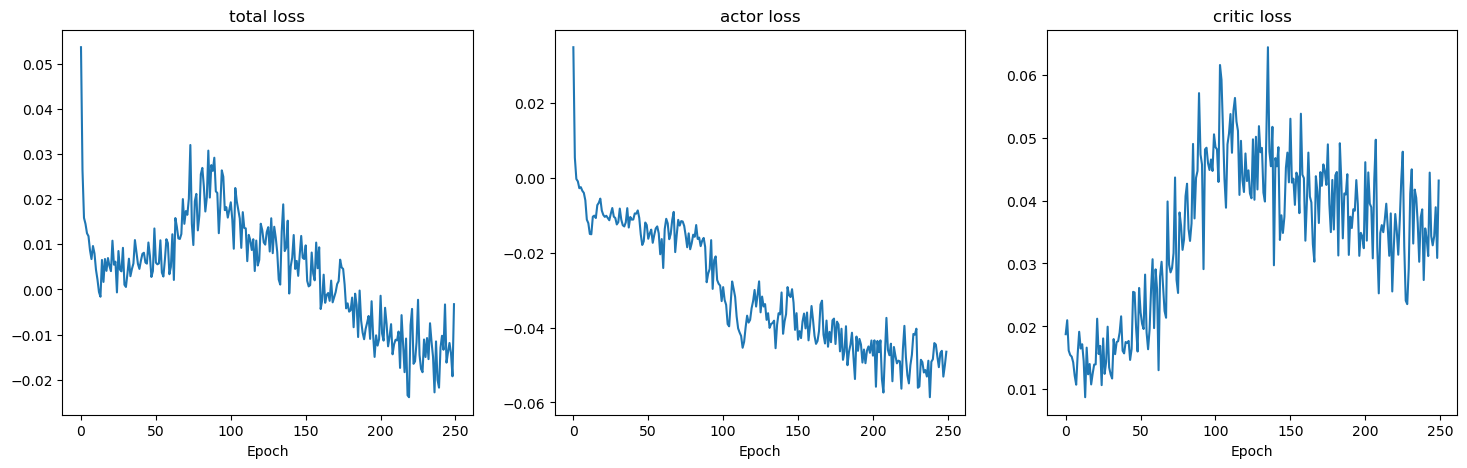

In [49]:
# Plot training curve
fig, ax = plt.subplots( 1, 3, figsize = (18, 5))
ax[0].plot(loss_hist)
ax[0].set_title("total loss")
ax[0].set_xlabel("Epoch")
ax[1].plot(actor_loss_hist)
ax[1].set_title("actor loss")
ax[1].set_xlabel("Epoch")
ax[2].plot(critic_loss_hist)
ax[2].set_title("critic loss")
ax[2].set_xlabel("Epoch")

In [50]:
# Computing hits list for trained actor 
f_trained = lambda drug, disease: sample_path(agent, trained_actor, drug, disease)
trained_hits_list = give_hits_list(n_samples, n_datapoints, f_trained, dataset)

100%|██████████| 100/100 [00:30<00:00,  3.30it/s]


In [51]:
# Compute Hit@k for trained actor 
hitk_trained =  give_hitk(trained_hits_list, k_lst)
print("Trained network:")
for hitk_val, k in zip(hitk_trained, k_lst): 
    print(f"Hit@{k}: {hitk_val}")

Trained network:
Hit@10: 0.45
Hit@100: 0.78
Hit@500: 0.91
Hit@1000: 0.94
